# 🎮 Proyek Akhir Data Science: Prediksi Penjualan Video Game
## BAB 1 & 2: Business & Data Understanding
*Code ini berasal dari file ETS_DS_137_196_231.ipynb yang sudah kamu buat.*

In [5]:
# === 1. SETUP & LOAD DATA (Ganti dataset ke Video Games) ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Konfigurasi Plot
sns.set(style="whitegrid")
%matplotlib inline

# Nama file yang diinginkan (letakkan file ini di working directory notebook)
file_name = 'Video_Games_Sales_as_at_22_Dec_2016.csv'

if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    print("✅ Dataset berhasil dimuat dari file lokal:", file_name)
    print("Dimensi:", df.shape)
else:
    print(f"❌ File '{file_name}' tidak ditemukan di working directory.")
    print("Silakan upload file tersebut ke working directory Jupyter atau berikan path yang benar.")
    # Contoh: jika file ada di path lain, ubah file_name menjadi path lengkap, lalu jalankan ulang cell.

✅ Dataset berhasil dimuat dari file lokal: Video_Games_Sales_as_at_22_Dec_2016.csv
Dimensi: (16719, 16)


In [6]:
print("\nContoh Data:")
print(df.head())


Contoh Data:
                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Dev


--- Missing Values ---
Name                  2
Year_of_Release     269
Genre                 2
Publisher            54
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64


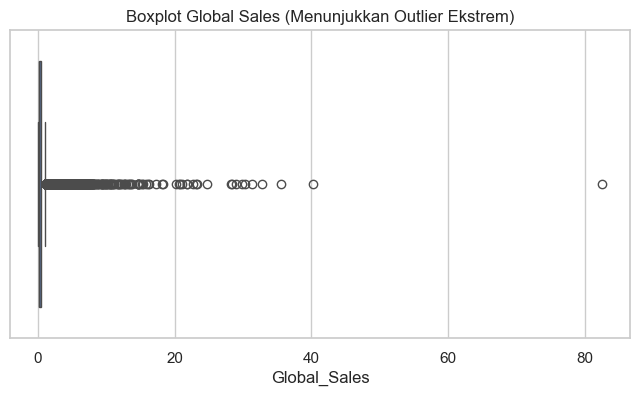

In [7]:
# === 2. DATA QUALITY CHECK (Dari Code Asli) ===

# Convert User_Score jadi numeric
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

# Cek Missing Value
print("\n--- Missing Values ---")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Cek Outlier Global Sales
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Global_Sales'])
plt.title('Boxplot Global Sales (Menunjukkan Outlier Ekstrem)')
plt.show()

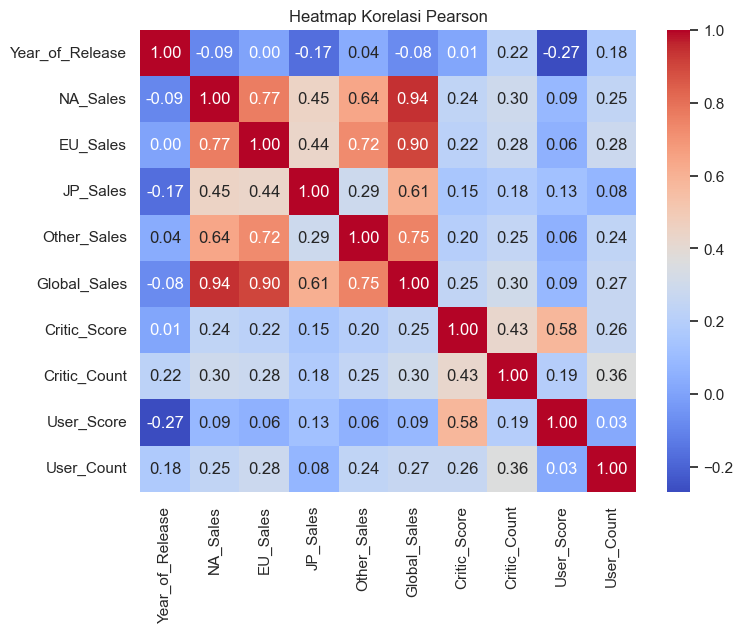

Korelasi Pearson (Critic_Score vs Global_Sales): r=0.245
Kesimpulan: Ada korelasi positif, cocok menggunakan Regresi.


In [8]:
# === 2.4 EDA & KORELASI (Dari Code Asli) ===

# Heatmap Korelasi
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Pearson')
plt.show()

# Bukti Hubungan Critic_Score vs Sales
mask = df[['Critic_Score','Global_Sales']].dropna()
r, p = stats.pearsonr(mask['Critic_Score'], mask['Global_Sales'])
print(f"Korelasi Pearson (Critic_Score vs Global_Sales): r={r:.3f}")
print("Kesimpulan: Ada korelasi positif, cocok menggunakan Regresi.")

---
## BAB 3: Data Preparation
Di sini kita membersihkan data agar siap untuk Machine Learning.

In [9]:
# 3.1 PEMBERSIHAN DATA (CLEANING)

# Hapus baris yang tidak punya skor review (karena kita mau validasi pengaruh review)
df_clean = df.dropna(subset=['Critic_Score', 'User_Score', 'Year_of_Release', 'Publisher']).copy()

# Ubah Tahun jadi Integer
df_clean['Year_of_Release'] = df_clean['Year_of_Release'].astype(int)

print(f"Data setelah cleaning: {df_clean.shape}")

Data setelah cleaning: (6893, 16)


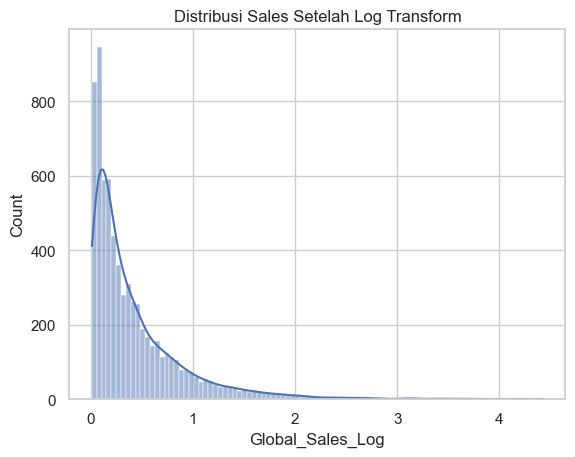

In [10]:
# 3.2 SELEKSI FITUR & TRANSFORMASI

# Buang kolom 'Bocoran' (Sales Regional) dan Identifier (Nama/Dev)
cols_to_drop = ['Name', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
df_model = df_clean.drop(columns=cols_to_drop)

# Log Transformation pada Target (Global Sales) untuk mengatasi outlier
df_model['Global_Sales_Log'] = np.log1p(df_model['Global_Sales'])

# Cek distribusi setelah Log
sns.histplot(df_model['Global_Sales_Log'], kde=True)
plt.title("Distribusi Sales Setelah Log Transform")
plt.show()

In [11]:
# 3.3 ENCODING & SPLITTING
from sklearn.model_selection import train_test_split

# Pisahkan Fitur (X) dan Target (y)
X_raw = df_model.drop(columns=['Global_Sales', 'Global_Sales_Log'])
y = df_model['Global_Sales_Log']

# One-Hot Encoding (Ubah Genre/Platform jadi angka)
X = pd.get_dummies(X_raw, drop_first=True)

# Split Data 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Siap untuk Modeling!")
print(f"Training Set: {X_train.shape}")
print(f"Testing Set : {X_test.shape}")

Siap untuk Modeling!
Training Set: (5514, 308)
Testing Set : (1379, 308)


---
## BAB 4: Modeling (Linear Regression)
Melatih model regresi linier sederhana.

In [12]:
from sklearn.linear_model import LinearRegression

# Inisialisasi & Latih Model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Prediksi
y_pred = model_lr.predict(X_test)

print("Model Linear Regression berhasil dilatih.")

Model Linear Regression berhasil dilatih.


---
## BAB 5: Evaluasi & Interpretasi
Mengukur akurasi dan menjawab tujuan bisnis.

R-Squared : 0.4424
RMSE      : 0.3536


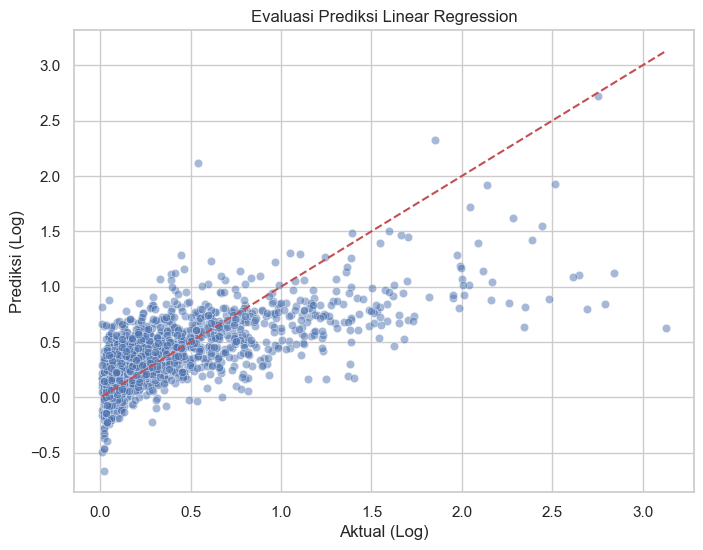

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 5.1 Hitung Metrik Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R-Squared : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")

# 5.2 Visualisasi Aktual vs Prediksi
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Aktual (Log)")
plt.ylabel("Prediksi (Log)")
plt.title("Evaluasi Prediksi Linear Regression")
plt.show()

In [14]:
# 5.3 VALIDASI TUJUAN BISNIS (Pengaruh Review)
coef = pd.Series(model_lr.coef_, index=X.columns)

critic_impact = coef.get('Critic_Score', 0)
user_impact = coef.get('User_Score', 0)

print(f"Dampak Critic Score: {critic_impact:.5f}")
print(f"Dampak User Score  : {user_impact:.5f}")

if critic_impact > user_impact:
    print("\nKESIMPULAN: Skor Kritikus lebih berpengaruh terhadap penjualan daripada Skor User.")
else:
    print("\nKESIMPULAN: Skor User lebih berpengaruh.")

Dampak Critic Score: 0.00907
Dampak User Score  : -0.02333

KESIMPULAN: Skor Kritikus lebih berpengaruh terhadap penjualan daripada Skor User.
